In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sns.set(style="darkgrid", font_scale=1.5)

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

After importing the libraries, we can now get the data we need:

In [4]:
df = pd.read_csv("../data/MorningTest6.csv")[['price']]

df.shape

(35400, 1)

In [5]:
df.head()

,price
0,1236.359013
1,1236.357396
2,1236.346090
3,1236.900815
4,1236.500028


As you can see, the data includes almost 1 million rows. I just need a part of which is the "open" prince of "litecoin".

In [6]:
df.shape

(35400, 1)

We now have the historical data of litecoin from April,2013 to November,2018. Let's take a look at how it changed through time.

Text(0.5, 1.0, 'Price of ETHER')

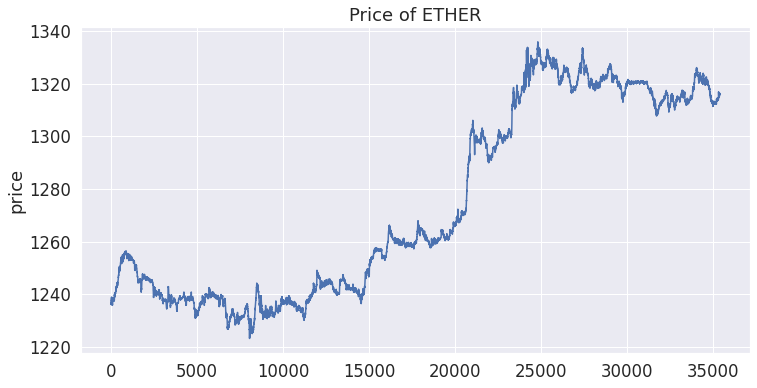

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y="price", data=df).set_title("Price of ETHER")

In [8]:
#df.resample('.01D').mean().plot(figsize=(12,6))
#plt.figtext(.5,0.9,"Down-sampled to 10-day periods", fontsize=20, ha='center')

# Model

Long short-term memory (LSTM) is a type of recurrent neural network (RNN) and powerful to model sequence data because it maintains an internal state to keep track of the data it has already seen. Common applications of LSTMs include time series analysis and natural language processing.

LSTM requires the input to be a 3D tensor with shape (batch_size, timesteps, input_dim).

Batch_size: 
Timesteps:
input_dim:

I will build a model that predicts the value of litecoin at time t using the past 90 values (from t-90 to t-1). Therefore the the number of timesteps is 90. I only use "open" price to make the prediction so the input_dim is 1. The target variable is "open" price of litecoin which can be effected by many other factors. For example, the value of another crptocurrency may have an effect on litecoin. If we also use a second variable to make the prediction, than the input_dim will be 2.

## Data Preprocessing

I will re-organize the data in a way that a sequence of the values in previous 90 days is used to predict the value at time t. It is also better to normalize the values due to excessive computations done in a neural network.

In [9]:
data = df.iloc[:, 0]
data

0        1236.359013
1        1236.357396
2        1236.346090
3        1236.900815
4        1236.500028
            ...     
35395    1315.866209
35396    1315.736291
35397    1315.700333
35398    1315.686817
35399    1315.364442
Name: price, Length: 35400, dtype: float64

In [10]:
hist = []
target = []
length = 90

for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [11]:
print("History is of length:\t", len(hist), "with each element representing", len(hist[0]), f"past prices t-{length} to t-1")
print("Target is of length:\t", len(target), f"with each element representing what the price at time t really is. Ex: target[0]=${target[0]}")

History is of length:	 35310 with each element representing 90 past prices t-90 to t-1
Target is of length:	 35310 with each element representing what the price at time t really is. Ex: target[0]=$1236.085


In [12]:
print(hist[0][length-1])
print(data[length-1])

1236.085
1236.085


The last timestep of the first element is same as the 90th timestep of the original data which is what we planned to do.

The second element of hist should be just one timestep shifted version of first element. Therefore, the last timestep in the second element should be equal to the first item of the target variable which is the 91st timestep in the original data.

Let's double check to confirm:

In [13]:
print(hist[1][length-1])
print(data[length])
print(target[0])

1236.085
1236.085
1236.085


In [14]:
print(type(hist), type(target))

<class 'list'> <class 'list'>


In [15]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [16]:
print(type(hist), type(target))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [17]:
hist.shape

(35310, 90)

In [18]:
target.shape

(35310,)

In [19]:
target = target.reshape(-1,1)
target.shape

(35310, 1)

In [20]:
#Normalize the values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [21]:
#Reshape the input
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

# hist scaled: Array of dims [length of origional data - length][length][1 (means each gets it's own box)]
print(hist_scaled[0][1])
print(hist_scaled[1][0])

(35310, 90, 1)
[0.1162803]
[0.1162803]


## Training and test sets

Our dataset includes 1951 samples (days). A sample of input consists of the value of litecoin for 90 consecutive days and target variable is the value of litecoin on the following day after the 90-day period.

I will split the dataset in a way that 1900 samples are used for training and then the model will be used to predict the trend in the following 51 days


In [22]:
points_for_testing = 8000
points_for_training = len(hist_scaled) - points_for_testing

X_train = hist_scaled[:points_for_training,:,:]
X_test = hist_scaled[points_for_training:,:,:]

y_train = target_scaled[:points_for_training,:]
y_test = target_scaled[points_for_training:,:]

print(f"Using {len(y_test)} datapoints for testing, leaving {len(y_train)} points for training")

Using 8000 datapoints for testing, leaving 27310 points for training


## Building the neural network

In [23]:
import tensorflow as tf

from tensorflow.keras import layers, optimizers

In [24]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(length,1), dropout=0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, dropout=0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


We have created a model with 3 LSTM layers and 1 dense layer. It is time to compile and train the model.

In [25]:
#lr_schedule = optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=50,
#    decay_rate=0.9)
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [26]:
history = model.fit(X_train, y_train, epochs=6, batch_size=32)

Epoch 1/6
854/854 [==============================] - 35s 38ms/step - loss: 0.0084
Epoch 2/6
854/854 [==============================] - 33s 38ms/step - loss: 8.6769e-04
Epoch 3/6
854/854 [==============================] - 34s 40ms/step - loss: 6.8766e-04
Epoch 4/6
854/854 [==============================] - 34s 40ms/step - loss: 3.9896e-04
Epoch 5/6
854/854 [==============================] - 35s 41ms/step - loss: 2.6136e-04
Epoch 6/6
854/854 [==============================] - 33s 39ms/step - loss: 2.3869e-04


It seems like the model is converged in 30 epochs so there is no need to do additional epochs. The loss is less than 0.002 which I think is pretty good. 

Let's visualize how loss changes as number of epochs increases.

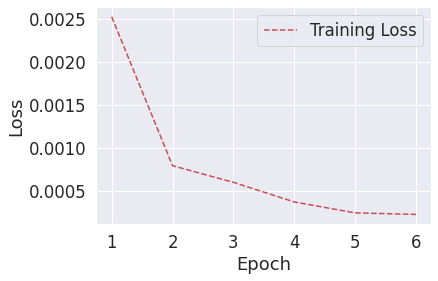

In [27]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(6,4))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predict

In [28]:
X_test.shape

(8000, 90, 1)

In [29]:
pred = model.predict(X_test)

In [30]:
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

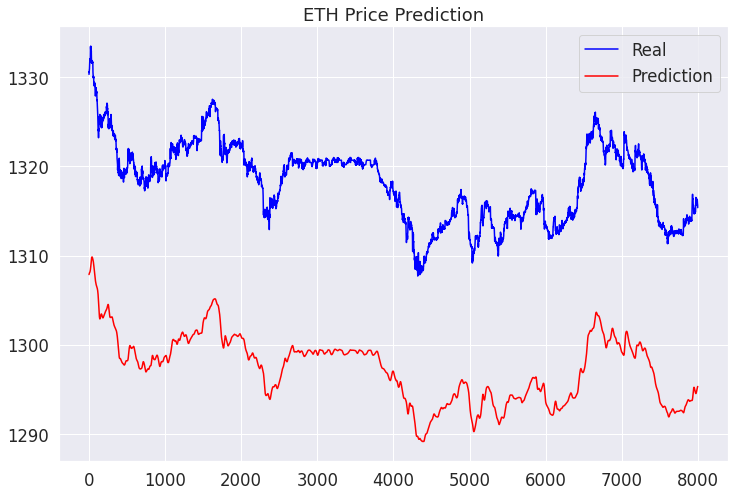

In [31]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('ETH Price Prediction')
plt.legend()
plt.show()

# Single Prediction

In [32]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
most_recent_period = df.tail(length)

# 2. convert to numpy array 
most_recent_period = np.array(most_recent_period)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)

# 6. Un-normalize the data
result = scaler.inverse_transform(prediction)

print(f"${result[0][0]}")

$1315.5386962890625


# Prediction Success Evaluation

In [34]:
def sub_sample(arr1, arr2, sub):
    return (arr1[::sub], arr2[::sub])

def evaluate_model(real_data, predicted_data):
    real_data = real_data.reshape(len(real_data))
    predicted_data = predicted_data.reshape(len(predicted_data))

    real_diff = np.diff(real_data)
    predicted_diff = np.diff(predicted_data)

    correct_slopes = 0
    for i in range(len(real_data)-1):
        if np.sign(real_diff[i]) == np.sign(predicted_diff[i]):
            correct_slopes = correct_slopes + 1
    return correct_slopes

real_subbed, pred_subbed = sub_sample(y_test_transformed, pred_transformed, 30)

correct_slopes = evaluate_model(real_subbed, pred_subbed)

print(f"Found {correct_slopes} out of {len(real_subbed)-1}")
precent_success = (correct_slopes/(len(real_subbed)-1)) * 100
print(f"{precent_success}%")


Found 186 out of 266
69.92481203007519%
